<a href="https://colab.research.google.com/github/cedenoorlando991/DeepLearningAssessment1/blob/main/AIT_09_Author_classification_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [3]:

import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split



## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:

train_data = pd.read_csv('/content/drive/MyDrive/data/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/data/test.csv')

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

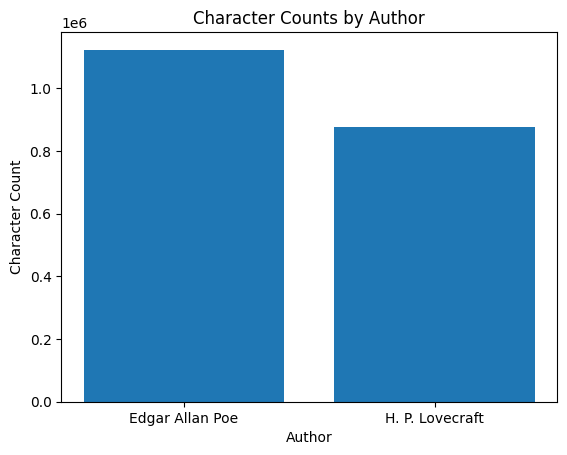

In [12]:
train_poe_chars = sum(train_data[train_data['author'] == 'EAP']['text'].str.len())
train_lovecraft_chars = sum(train_data[train_data['author'] == 'HPL']['text'].str.len())

authors = ['Edgar Allan Poe', 'H. P. Lovecraft']
train_counts = [train_poe_chars, train_lovecraft_chars]
fig, ax = plt.subplots()
ax.bar(authors, train_counts)
ax.set_xlabel('Author')
ax.set_ylabel('Character Count')
ax.set_title('Character Counts by Author')
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

This code block was assisted using chatGPT :) my test set didn't have a 'author' column so converting the entire dataset into one-hot encodings was difficult.


In [41]:
import tensorflow.keras.utils as ku

combined_data = pd.concat([train_data, test_data])

unique_chars = sorted(set(''.join(combined_data['text'].values)))

char_to_index = dict((c, i) for i, c in enumerate(unique_chars))

max_seq_length = 60

def text_to_one_hot(text, max_seq_length, char_to_index):
    sequence = [char_to_index[c] for c in text if c in char_to_index]
    sequence = sequence[:max_seq_length] + [0] * (max_seq_length - len(sequence))
    one_hot = ku.to_categorical(sequence, num_classes=len(char_to_index))
    return one_hot

def generate_dataset(data, max_seq_length, char_to_index):
    sequences = []
    labels = []
    if 'author' in data.columns:
        for i, row in data.iterrows():
            text = row['text']
            author = row['author']
            sequence = text_to_one_hot(text, max_seq_length, char_to_index)
            sequences.append(sequence)
            if author == 'EAP':
                label = [1, 0]
            elif author == 'HPL':
                label = [0, 1]
            labels.append(label)
    else:
        for i, row in data.iterrows():
            text = row['text']
            sequence = text_to_one_hot(text, max_seq_length, char_to_index)
            sequences.append(sequence)
            labels.append([0, 0])
    return np.array(sequences), np.array(labels)


train_sequences, train_labels = generate_dataset(train_data, max_seq_length, char_to_index)
test_sequences, test_labels = generate_dataset(test_data, max_seq_length, char_to_index)

print("Training set shape:", train_sequences.shape, train_labels.shape)
print("Test set shape:", test_sequences.shape, test_labels.shape)



Training set shape: (19579, 60, 87) (19579, 2)
Test set shape: (8392, 60, 87) (8392, 2)


## Data splitting
Split the data into train, validate and test sets. Make 

In [43]:
train_sequences, val_sequences, train_labels, val_labels = train_test_split(
    train_sequences, train_labels, test_size=0.2, random_state=42)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [44]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(128, input_shape=(max_seq_length, len(char_to_index))))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model training
Train the model and apply early stopping.

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_sequences, train_labels, 
                    validation_data=(val_sequences, val_labels),
                    epochs=20, batch_size=128, callbacks=[early_stopping])

Epoch 1/20
123/123 [==============================] - 31s 234ms/step - loss: 0.6706 - accuracy: 0.5871 - val_loss: 0.6610 - val_accuracy: 0.6134
Epoch 2/20
123/123 [==============================] - 29s 235ms/step - loss: 0.6532 - accuracy: 0.6174 - val_loss: 0.6470 - val_accuracy: 0.6274
Epoch 3/20
123/123 [==============================] - 28s 230ms/step - loss: 0.6484 - accuracy: 0.6256 - val_loss: 0.6495 - val_accuracy: 0.6233
Epoch 4/20
123/123 [==============================] - 30s 245ms/step - loss: 0.6400 - accuracy: 0.6328 - val_loss: 0.6457 - val_accuracy: 0.6236
Epoch 5/20
123/123 [==============================] - 29s 239ms/step - loss: 0.6377 - accuracy: 0.6363 - val_loss: 0.6471 - val_accuracy: 0.6251
Epoch 6/20
123/123 [==============================] - 30s 247ms/step - loss: 0.6367 - accuracy: 0.6389 - val_loss: 0.6417 - val_accuracy: 0.6269
Epoch 7/20
123/123 [==============================] - 28s 231ms/step - loss: 0.6350 - accuracy: 0.6377 - val_loss: 0.6403 - val_ac

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [45]:
loss, accuracy = model.evaluate(test_sequences, test_labels)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

263/263 [==============================] - 10s 33ms/step - loss: 0.0000e+00 - accuracy: 0.8855
Test Loss: 0.0
Test Accuracy: 0.8854861855506897


## Confusion matrix
Calculate and display the confusion matrix.

In [46]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_sequences)

y_pred_labels = np.argmax(y_pred, axis=1)
test_labels_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(test_labels_labels, y_pred_labels)

print(cm)

263/263 [==============================] - 9s 32ms/step
[[7431  961]
 [   0    0]]
